In [1]:
%pip install numpy scipy scikit-learn matplotlib networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

In [3]:
def load_graph(file_path):
    graph = nx.read_edgelist(file_path, delimiter=",")
    return graph

In [4]:
file_path = "example1.dat"
graph = load_graph(file_path)
graph

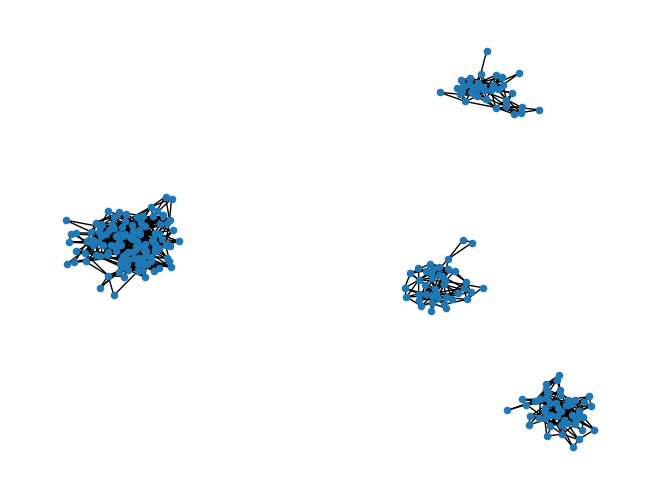

In [5]:
nx.draw(graph, node_size=20)

In [6]:
def build_affinity_matrix(edges, num_points, sigma=1.0):
    A = np.zeros((num_points, num_points))
    for i, j in edges:
        i = int(i)
        j = int(j)
        if i != j:
            A[i - 1, j - 1] = np.exp(-1 / (2 * sigma ** 2))  # Example weight calculation
            A[j - 1, i - 1] = A[i - 1, j - 1]  # Symmetric matrix
    return A

In [7]:
num_nodes = np.unique(np.asarray(graph)).shape[0]
num_nodes


241

In [8]:
A = build_affinity_matrix(nx.edges(graph), num_nodes)
A

array([[0.        , 0.60653066, 0.60653066, ..., 0.        , 0.        ,
        0.        ],
       [0.60653066, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.60653066, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
def construct_diagonal(A):
    return np.diag(np.sum(A, axis=1))

In [10]:
D = construct_diagonal(A)
D

array([[4.24571462, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.85224528, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 5.45877594, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.21306132, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.0326533 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.21306132]])

In [11]:
def construct_L(A, D):
    D_inv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
    L = D_inv_sqrt @ A @ D_inv_sqrt
    return L

In [12]:
L = construct_L(A, D)
L

array([[0.        , 0.13363062, 0.12598816, ..., 0.        , 0.        ,
        0.        ],
       [0.13363062, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12598816, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
def get_eigen(L):
    eigvals, eigvecs = eigh(L)
    return eigvals, eigvecs

In [14]:
k = 4
eigvals, eigvecs = get_eigen(L)
X = eigvecs[:, num_nodes - k:]
X

array([[ 0.        ,  0.        , -0.0867576 ,  0.        ],
       [ 0.        ,  0.        , -0.09274778,  0.        ],
       [ 0.        ,  0.        , -0.09837388,  0.        ],
       [ 0.        ,  0.        , -0.11359237,  0.        ],
       [ 0.        ,  0.        , -0.11823068,  0.        ],
       [ 0.        ,  0.        , -0.08032193,  0.        ],
       [ 0.        ,  0.        , -0.04637389,  0.        ],
       [ 0.        ,  0.        , -0.07332356,  0.        ],
       [ 0.        ,  0.        , -0.12269378,  0.        ],
       [ 0.        ,  0.        , -0.12700013,  0.        ],
       [ 0.        ,  0.        , -0.13116517,  0.        ],
       [ 0.        ,  0.        , -0.13116517,  0.        ],
       [ 0.        ,  0.        , -0.12700013,  0.        ],
       [ 0.        ,  0.        , -0.10369517,  0.        ],
       [ 0.        ,  0.        , -0.16720344,  0.        ],
       [ 0.        ,  0.        , -0.12269378,  0.        ],
       [ 0.        ,  0.

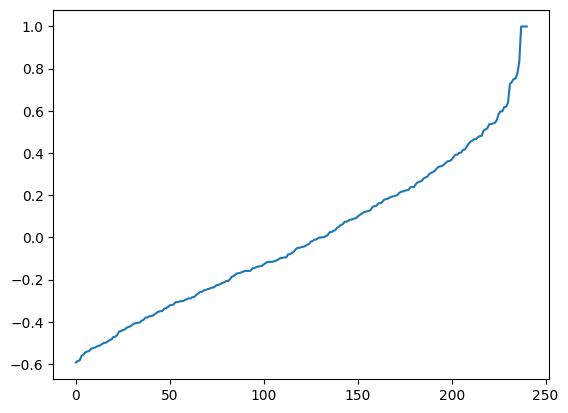

In [15]:
plt.plot(eigvals)
plt.show()

In [16]:
def renormalize_rows(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

In [17]:
Y = renormalize_rows(X)
Y

array([[ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  

In [18]:
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(Y)

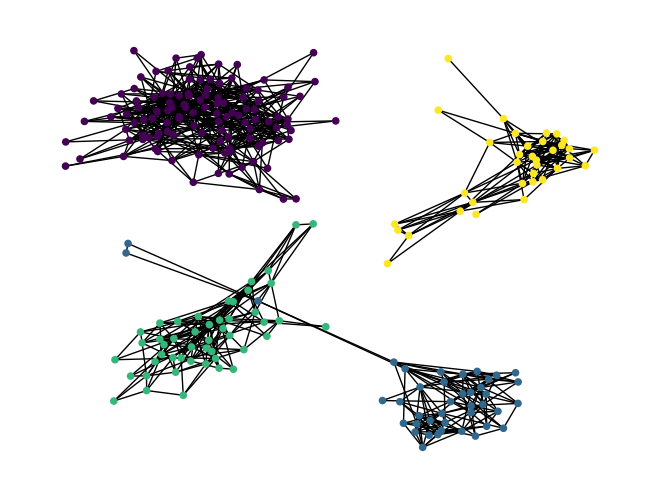

In [19]:
nx.draw(graph, node_size=20, pos=nx.spring_layout(graph, k=0.05, iterations=20), node_color=clusters)

In [21]:
A2 = np.zeros([num_nodes, num_nodes])
for i, j in nx.edges(graph):
    i = int(i)
    j = int(j)
    A2[i-1, j-1] = 1  # Adjusting for 0-based indexing
    A2[j-1, i-1] = 1  # Assuming undirected graph

In [22]:
L2 = D - A2
L2

array([[ 4.24571462, -1.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        ,  4.85224528,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        ,  0.        ,  5.45877594, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.21306132,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.0326533 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.21306132]])

In [23]:
eigvals2, eigvecs2 = eigh(L2)

In [24]:
FV = eigvecs2[:, 1]

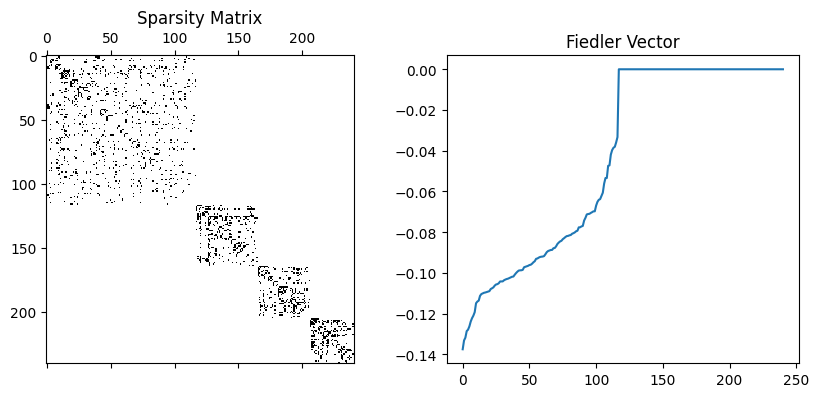

In [27]:
fig=plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.spy(A) 
plt.title('Sparsity Matrix')
plt.subplot(1,2,2)
plt.plot(np.sort(FV))
plt.title('Fiedler Vector')
plt.show()